In [13]:
import matplotlib.pyplot as plt
from DataLoader import  DataLoader

In [14]:
class_names = [
    "Wall",
    "Sky",
    "Tree",
    "Route",
    "Grass", 
    "Earth", 
    "Mountain",
    "Plant",
    "Water",
    "Sea", 
    "Field",
    "Rock",
    "Sand",
    "River",
    "Hill",
    "Land",
    "Waterfall",
]

In [15]:
class_merge_map = {
    9:8, 13:8, 4:10, 7:2, 
}

dataloader = DataLoader(class_merge_map=class_merge_map)
dataloader.load_data(1000)

image, mask = dataloader.get_image(1)
images, masks = dataloader[:100]

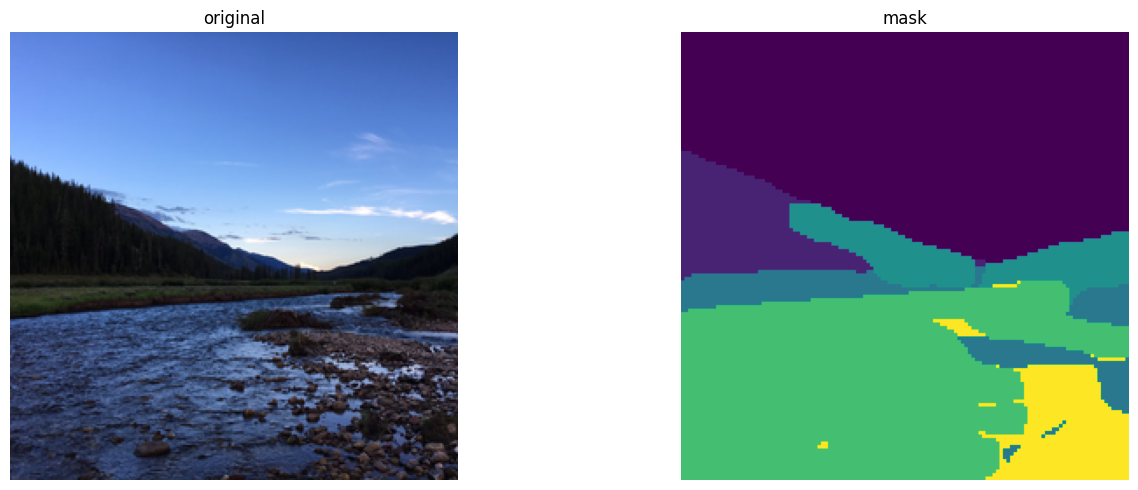

In [16]:
def visualize_process(images, titles):
    n = len(images)
    fig, ax = plt.subplots(1, n, figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax[i].imshow(image)
        ax[i].set_title(title)
        ax[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_process([image, mask], ['original', 'mask'])

In [17]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.filters import gabor_kernel
from scipy.ndimage import convolve
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from typing import Tuple, List

def resize(image: np.ndarray, mask: np.ndarray, scale: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    """Resize image and mask by a scaling factor."""
    img_resized = cv2.resize(image, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    return img_resized, mask_resized

def equalize_hist(image: np.ndarray) -> np.ndarray:
    """Perform histogram equalization on a grayscale or RGB image."""
    if image.ndim == 2:
        return cv2.equalizeHist(image)
    channels = cv2.split(image)
    equalized_channels = [cv2.equalizeHist(chan) for chan in channels]
    return cv2.merge(equalized_channels)

def superpixel_segmentation(image: np.ndarray, n_segments: int = 100) -> np.ndarray:
    """Segment an image into superpixels."""
    return slic(image, n_segments=n_segments, compactness=10, start_label=1)

def extract_hist(image: np.ndarray, segments: np.ndarray, superpixel_id: int) -> np.ndarray:
    """Extract a histogram for a specific superpixel."""
    mask_segment = (segments == superpixel_id).astype(np.uint8)
    hist = cv2.calcHist([image], [0, 1, 2], mask_segment, [3, 3, 3], [0, 256, 0, 256, 0, 256])
    return hist.flatten()

def generate_gabor_filter_bank(frequency: float = 0.1, n_orientations: int = 6) -> List[np.ndarray]:
    """Generate a Gabor filter bank with specified frequency and orientations."""
    return [
        gabor_kernel(frequency, theta=theta)
        for theta in np.linspace(0, np.pi, n_orientations, endpoint=False)
    ]

def extract_gabor_features(image: np.ndarray, filter_bank: List[np.ndarray]) -> np.ndarray:
    """Apply Gabor filters to an image and collect the responses."""
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    responses = [convolve(image, np.real(kernel), mode='reflect') for kernel in filter_bank]
    return np.stack(responses, axis=-1)

def compute_superpixel_features(
    segments: np.ndarray, gabor_responses: np.ndarray
) -> np.ndarray:
    """Compute features for each superpixel using Gabor filter responses."""
    num_superpixels = segments.max()
    num_filters = gabor_responses.shape[-1]
    features = np.zeros((num_superpixels, num_filters))

    for sp_label in range(1, num_superpixels + 1):
        mask = segments == sp_label
        for f in range(num_filters):
            response = gabor_responses[..., f]
            features[sp_label - 1, f] = response[mask].mean()
    return features

def extract_features(
    images: List[np.ndarray], masks: List[np.ndarray], gabor_filter_bank: List[np.ndarray]
) -> Tuple[np.ndarray, np.ndarray]:
    """Extract features and labels from a list of images and masks."""
    all_features, all_labels = [], []

    for image, mask in zip(images, masks):
        processed_image = equalize_hist(image)
        segments = superpixel_segmentation(processed_image)
        gabor_responses = extract_gabor_features(processed_image, gabor_filter_bank)

        num_superpixels = segments.max()
        image_features = []
        superpixel_labels = []

        for sp_label in range(1, num_superpixels + 1):
            sp_mask = segments == sp_label

            # Gabor features
            gabor_features = [
                gabor_responses[..., f][sp_mask].mean()
                for f in range(gabor_responses.shape[-1])
            ]

            # Histogram features
            hist = extract_hist(processed_image, segments, sp_label)
            hist_features = [
                hist.mean(), hist.var(), skew(hist), kurtosis(hist), np.sum(hist**2)
            ]

            # Combine features
            image_features.append(gabor_features + hist_features)

            # Determine superpixel label
            pixel_labels = mask[sp_mask].flatten()
            if pixel_labels.size > 0:
                superpixel_labels.append(np.bincount(pixel_labels).argmax())
            else:
                superpixel_labels.append(-1)

        all_features.append(np.array(image_features))
        all_labels.append(np.array(superpixel_labels))

    return np.vstack(all_features), np.hstack(all_labels)

In [18]:
gabor_filter_bank = generate_gabor_filter_bank()
features, labels = extract_features(images, masks, gabor_filter_bank)

In [19]:
features.shape, labels.shape

((5815, 11), (5815,))

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [ ]:
from thundergbm import TGBMClassifier

clf = TGBMClassifier(objective='multi:softmax', verbose=2)
clf.fit(x_train, y_train)

In [10]:
y_pred = clf.predict(x_test)

2024-12-11 13:38:00,868 INFO [default] #instances = 216, #features = 11
2024-12-11 13:38:00,884 INFO [default] use shared memory to predict
2024-12-11 13:38:00,884 INFO [default] Done y transform size is 216


In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Accuracy: 0.56

Classification Report:


ValueError: Number of classes, 9, does not match size of target_names, 17. Try specifying the labels parameter

282x29